In [1]:
!pip install -q grad-cam

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

import torch
import torchvision
import timm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.v2 as t
from torchvision import models
import torch.nn as nn
from sklearn.metrics import accuracy_score, roc_auc_score
import torch.nn.functional as F
from tabulate import tabulate
from sklearn.model_selection import KFold, StratifiedKFold
import gc
import timm 
from torch.optim.lr_scheduler import ReduceLROnPlateau
from IPython import display
display.clear_output()


In [3]:
import random
import tensorflow as tf
import os
import json
def seeding(SEED):
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
#     os.environ['TF_CUDNN_DETERMINISTIC'] = str(SEED)
    tf.random.set_seed(SEED)
    print('seeding done!!!')
seeding(42)

seeding done!!!


#### Load data

In [5]:
train_df=pd.read_csv('/kaggle/input/new-embryo-split/train.csv')
valid_df=pd.read_csv('/kaggle/input/new-embryo-split/val.csv')
test_df =pd.read_csv('/kaggle/input/new-embryo-split/test.csv')
train_df.shape, valid_df.shape, test_df.shape

((2150, 2), (538, 2), (168, 2))

In [6]:
data_path = '/kaggle/input/new-embryo-split/train_aug-20240126T142651Z-001/train_aug/'
train_df['Image'] = train_df['Image'].apply(lambda x: data_path + x.split('/')[-1])
valid_df['Image'] = valid_df['Image'].apply(lambda x: data_path + x.split('/')[-1])

train_df.head()

,Image,Class
0,/kaggle/input/new-embryo-split/train_aug-20240...,0
1,/kaggle/input/new-embryo-split/train_aug-20240...,0
2,/kaggle/input/new-embryo-split/train_aug-20240...,0
3,/kaggle/input/new-embryo-split/train_aug-20240...,0
4,/kaggle/input/new-embryo-split/train_aug-20240...,0


In [7]:
test_df.head()

,Image,Class
0,/kaggle/input/world-championship-2023-embryo-c...,0
1,/kaggle/input/world-championship-2023-embryo-c...,0
2,/kaggle/input/world-championship-2023-embryo-c...,0
3,/kaggle/input/world-championship-2023-embryo-c...,0
4,/kaggle/input/world-championship-2023-embryo-c...,0


In [8]:

def preprocess_jpeg(jpeg_path):
    
    img = cv2.imread(jpeg_path)
#     greyscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    
    return img

In [9]:

class EmbryoData(Dataset):
    def __init__(self, df, current_fold, training=True, num_fold = 3):
        super().__init__()
#         self.img_paths = fetch_img_paths(df_path)
#         self.df = pd.read_csv(df_path)
        self.df = df
        self.train = training
        if training:
            self.transform = transforms.Compose([
                            t.RandomHorizontalFlip(p=0.5),  # Randomly flip images left-right
                            t.RandomVerticalFlip(p=0.5),
                            t.RandomRotation(degrees=15),
                            # Add more augmentations as necessary
                            t.Resize((256, 256)),
                            t.ToTensor(),
                        ])
        else:
            self.transform = transforms.Compose([
                            t.Resize((256, 256)),
                            t.ToTensor(),
                        ])
        self.num_fold = num_fold
        self.current_fold = current_fold
        self.kf = KFold(n_splits=num_fold)
        self.skf = StratifiedKFold(n_splits=num_fold, shuffle=True)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img = preprocess_jpeg(self.df['Image'][idx])
#         img = remove_small_objects(img)
#         img = filter_max_area(img)
        
#         image = torch.tensor(img, dtype = torch.float)
        if self.train:
            image = self.transform(img)
            label = self.df['Class'][idx]
            return image, label
        else:
            image = self.transform(img)
#             id = self.df['Image'][idx]
            return image
    
    def get_splits(self):
        """
        Splits the dataset into training and validation subsets based on the current fold.
        
        Returns:
            tuple: A tuple containing the training and validation subsets.
        """
        
#         fold_data = list(self.kf.split(self.df['path']))
        fold_data = list(self.skf.split(self.df['path'], self.df['Class']))
        train_indices, val_indices = fold_data[self.current_fold]

        train_data = self._get_subset(train_indices, training=True)
        val_data = self._get_subset(val_indices, training=False)
        
        return train_data, val_data

    def _get_subset(self, indices, training):
        """
        Returns a subset of the dataset based on the provided indices.
        
        Args:
            indices (list): List of indices to include in the subset.
        
        Returns:
            Subset: A subset of the dataset.
        """
        self.training = training
        return Subset(self, indices)
        

In [10]:
BATCH_SIZE = 4  # Adjust as needed
NUM_EPOCHS = 20
LR = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
threshold = 0.3

cuda


In [11]:
train_df['Image']

0       /kaggle/input/new-embryo-split/train_aug-20240...
1       /kaggle/input/new-embryo-split/train_aug-20240...
2       /kaggle/input/new-embryo-split/train_aug-20240...
3       /kaggle/input/new-embryo-split/train_aug-20240...
4       /kaggle/input/new-embryo-split/train_aug-20240...
                              ...                        
2145    /kaggle/input/new-embryo-split/train_aug-20240...
2146    /kaggle/input/new-embryo-split/train_aug-20240...
2147    /kaggle/input/new-embryo-split/train_aug-20240...
2148    /kaggle/input/new-embryo-split/train_aug-20240...
2149    /kaggle/input/new-embryo-split/train_aug-20240...
Name: Image, Length: 2150, dtype: object

#### Seperate dataset into D3 and D5 data

In [12]:
D3 = train_df['Image'].apply(lambda x: 'D3_' in x)
train_df_d3 = train_df[D3].reset_index().drop(['index'], axis=1)
D3_val = valid_df['Image'].apply(lambda x: 'D3_' in x)
val_df_d3 = valid_df[D3_val].reset_index().drop(['index'], axis=1)
D3_test = test_df['Image'].apply(lambda x: 'D3_' in x)
test_df_d3 = test_df[D3_test].reset_index().drop(['index'], axis=1)
train_df_d3.shape, val_df_d3.shape, test_df_d3.shape

((1433, 2), (359, 2), (112, 2))

In [13]:
D5 = train_df['Image'].apply(lambda x: 'D5_' in x)
train_df_d5 = train_df[D5].reset_index().drop(['index'], axis=1)
D5_val = valid_df['Image'].apply(lambda x: 'D5_' in x)
val_df_d5 = valid_df[D5_val].reset_index().drop(['index'], axis=1)
D5_test = test_df['Image'].apply(lambda x: 'D5_' in x)
test_df_d5 = test_df[D5_test].reset_index().drop(['index'], axis=1)
train_df_d5.shape, val_df_d5.shape, test_df_d5.shape

((717, 2), (179, 2), (56, 2))

In [15]:
train_data_all = EmbryoData(train_df, current_fold=0)
valid_data_all = EmbryoData(valid_df, current_fold=0)
test_data_all = EmbryoData(test_df, current_fold=0)
train_dataloader_all = DataLoader(train_data_all,batch_size = BATCH_SIZE, shuffle = True)
val_dataloader_all = DataLoader(valid_data_all,batch_size = BATCH_SIZE, shuffle = False)
test_dataloader_all = DataLoader(test_data_all,batch_size = BATCH_SIZE, shuffle = False)

dataloaders_all = [(train_dataloader_all, val_dataloader_all)]
dataloaders_all

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


[(<torch.utils.data.dataloader.DataLoader at 0x7833071b6170>,
  <torch.utils.data.dataloader.DataLoader at 0x7833071b4280>)]

In [16]:
train_data_d3 = EmbryoData(train_df_d3, current_fold=0)
valid_data_d3 = EmbryoData(val_df_d3, current_fold=0)
test_data_d3 = EmbryoData(test_df_d3, current_fold=0)
train_dataloader_d3 = DataLoader(train_data_d3,batch_size = BATCH_SIZE, shuffle = True)
val_dataloader_d3 = DataLoader(valid_data_d3,batch_size = BATCH_SIZE, shuffle = False)
test_dataloader_d3 = DataLoader(test_data_d3,batch_size = BATCH_SIZE, shuffle = False)

dataloaders_d3 = [(train_dataloader_d3, val_dataloader_d3)]
dataloaders_d3


[(<torch.utils.data.dataloader.DataLoader at 0x7833071b74c0>,
  <torch.utils.data.dataloader.DataLoader at 0x783307195cf0>)]

In [17]:
train_data_d5 = EmbryoData(train_df_d5, current_fold=0)
valid_data_d5 = EmbryoData(val_df_d5, current_fold=0)
test_data_d5 = EmbryoData(test_df_d5, current_fold=0)

train_dataloader_d5 = DataLoader(train_data_d5,batch_size = BATCH_SIZE, shuffle = True)
val_dataloader_d5 = DataLoader(valid_data_d5,batch_size = BATCH_SIZE, shuffle = False)
test_dataloader_d5 = DataLoader(test_data_d5,batch_size = BATCH_SIZE, shuffle = False)

dataloaders_d5 = [(train_dataloader_d5, val_dataloader_d5)]
dataloaders_d5


[(<torch.utils.data.dataloader.DataLoader at 0x783307197100>,
  <torch.utils.data.dataloader.DataLoader at 0x783307197c40>)]

#### Define model

In [19]:

class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.feature_extractor = models.efficientnet_b7(weights = 'IMAGENET1K_V1')        
        f = self.feature_extractor.classifier[1].in_features
        self.feature_extractor.classifier[1] = nn.Identity()
        
        self.logit = nn.Sequential(
            nn.Linear(f, 32),
            nn.SiLU(),
            nn.Dropout(0.4),
            nn.Linear(32, 1)
        )
        
    def forward(self, x):
        x = self.feature_extractor(x)
        
        output = self.logit(x)
#         output = self.sigmoid(output)
        output = output.squeeze(1)
        
        return output
        

In [20]:
model_all = CNNModel().to(device)
model_d3 = CNNModel().to(device)
model_d5 = CNNModel().to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-dcc49843.pth
100%|██████████| 255M/255M [00:01<00:00, 178MB/s] 


In [22]:
class MetricsCalculator:
    
    def __init__(self):
        
        self.probabilities = []
        self.predictions = []
        self.targets = []
        
    
    def update(self, logits, target):
        """
        Update the metrics calculator with predicted values and corresponding targets.
        
        Args:
            predicted (torch.Tensor): Predicted values.
            target (torch.Tensor): Ground truth targets.
        """
        probabilities = torch.sigmoid(logits)
        predicted = (probabilities > 0.5)
            
        self.probabilities.extend(probabilities.detach().cpu().numpy())
        self.predictions.extend(predicted.detach().cpu().numpy())
        self.targets.extend(target.detach().cpu().numpy())
    
    def reset(self):
        """Reset the stored predictions and targets."""
        
        self.probabilities = []
        self.predictions = []
        self.targets = []
    
    def compute_accuracy(self):
        """
        Compute the accuracy metric.
        
        Returns:
            float: Accuracy.
        """
        return accuracy_score(self.targets, self.predictions)
    
    def compute_auc(self):
        """
        Compute the AUC (Area Under the Curve) metric.
        
        Returns:
            float: AUC.
        """
        
        return roc_auc_score(self.targets, self.probabilities)

In [23]:
# plot training log
def plot(train_loss, train_acc, test_loss, test_acc):    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].set_title('Loss')
    ax[0].plot(train_loss,marker = '.',mec = 'r', mfc = 'r', label = 'train')
    ax[0].plot(test_loss,marker = '.',mec = 'r', mfc = 'r',color="green", label = 'val')
    ax[0].set_xticks(np.arange(len(train_loss)), labels = np.arange(1, len(train_loss)+1))
    ax[0].legend()

    ax[1].set_title('Accuracy')
    ax[1].plot(train_acc,marker = '.',mec = 'r', mfc = 'r', label = 'train')
    ax[1].plot(test_acc,marker = '.',mec = 'r', mfc = 'r',color="green", label = 'val')
    ax[1].set_xticks(np.arange(len(train_acc)), labels=np.arange(1,len(train_acc)+1))
    ax[1].legend()
    
#     plt.suptitle(title)
    plt.show()

#### Train model

In [24]:
def train(dataloaders, model):
    
    train_loss_data, valid_loss_data = [], []
    train_acc_data, valid_acc_data = [], []
    prev_val_best_loss = float('inf')
    best_model = None
    train_acc = MetricsCalculator()
    val_acc = MetricsCalculator()
    
    optimizer = torch.optim.Adam(model.parameters(), lr = LR)
    bce_ = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([2.0]).to(device))
    # bce = nn.BCELoss() 
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)
    
    for epoch in range(NUM_EPOCHS):

        # training
        model.train()

        train_loss = 0.0
        val_loss = 0.0

        print(f'Epoch: [{epoch + 1}/{NUM_EPOCHS}]')

        train_loader, val_loader = dataloaders[epoch%1]
        for idx, data in enumerate(train_loader):
            images, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(images)

            loss = bce_(outputs, labels.float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            train_acc.update(outputs, labels)

        train_loss = train_loss/(idx+1)

        # validation
        model.eval()    
        for idx, data in enumerate(val_loader):
            inputs, labels = data[0].to(device), data[1].to(device)


            outputs = model(inputs)
            loss = bce_(outputs, labels.float())
            val_loss += loss.item()
            val_acc.update(outputs, labels)

        val_loss = val_loss/(idx+1)
        scheduler.step(val_loss)
    
        train_loss_data.append(train_loss)
        valid_loss_data.append(val_loss)
        train_acc_data.append(train_acc.compute_accuracy())
        valid_acc_data.append(val_acc.compute_accuracy())
        
        if val_loss < prev_val_best_loss:
            prev_val_best_loss = val_loss
            print("Validation Loss improved, Saving Model...")
            best_model = model
#             torch.save(model, f'resnet152_{epoch}_{val_loss:.3f}.pth')

        metrics = [[train_acc.compute_accuracy(),
                    val_acc.compute_accuracy(),
                  train_acc.compute_auc(),
                  val_acc.compute_auc()]]

        # verbose
        print('')
        print(tabulate(metrics, headers=["Train Acc", "Val Acc", "Train AUC", "Val AUC"]))

        print(f'\nMean Train Loss: {train_loss:.3f}')
        print(f'Mean Val Loss: {val_loss:.3f}\n')

        # reset metrics
        train_acc.reset()
        val_acc.reset()
        
    return best_model, train_loss_data, valid_loss_data, train_acc_data, valid_acc_data

Epoch: [1/20]
Validation Loss improved, Saving Model...

  Train Acc    Val Acc    Train AUC    Val AUC
-----------  ---------  -----------  ---------
   0.807442   0.894052     0.831866   0.912068

Mean Train Loss: 0.531
Mean Val Loss: 0.362

Epoch: [2/20]
Validation Loss improved, Saving Model...

  Train Acc    Val Acc    Train AUC    Val AUC
-----------  ---------  -----------  ---------
    0.90093   0.895911     0.932919   0.948884

Mean Train Loss: 0.325
Mean Val Loss: 0.298

Epoch: [3/20]

  Train Acc    Val Acc    Train AUC    Val AUC
-----------  ---------  -----------  ---------
   0.942791    0.85316     0.973029   0.966314

Mean Train Loss: 0.208
Mean Val Loss: 0.339

Epoch: [4/20]

  Train Acc    Val Acc    Train AUC    Val AUC
-----------  ---------  -----------  ---------
   0.971163     0.8829     0.991799   0.966893

Mean Train Loss: 0.110
Mean Val Loss: 0.323

Epoch: [5/20]
Validation Loss improved, Saving Model...

  Train Acc    Val Acc    Train AUC    Val AUC
----

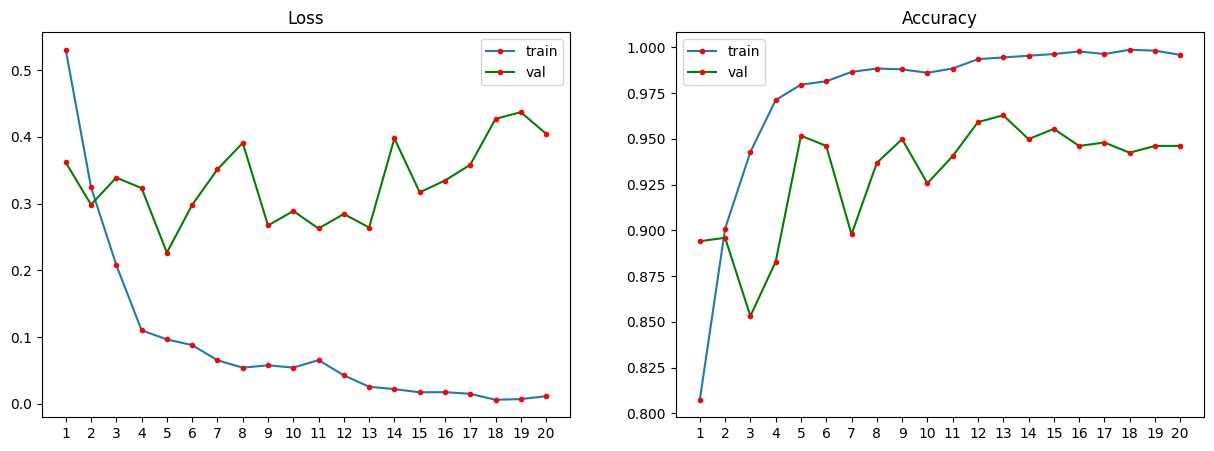

In [25]:
best_model_all, train_loss, test_loss, train_acc, test_acc = train(dataloaders_all, model_all)
logs = {'train_loss': train_loss, 'train_acc': train_acc, 'valid_loss': test_loss, 'valid_acc': test_acc}
with open(f'ours_all_training_logs.json', 'w') as f:
    json.dump(logs, f)
plot(train_loss, train_acc, test_loss, test_acc)

Epoch: [1/20]
Validation Loss improved, Saving Model...

  Train Acc    Val Acc    Train AUC    Val AUC
-----------  ---------  -----------  ---------
   0.924634   0.963788     0.574178   0.662104

Mean Train Loss: 0.394
Mean Val Loss: 0.292

Epoch: [2/20]

  Train Acc    Val Acc    Train AUC    Val AUC
-----------  ---------  -----------  ---------
   0.947662   0.835655      0.87286   0.838617

Mean Train Loss: 0.207
Mean Val Loss: 0.320

Epoch: [3/20]
Validation Loss improved, Saving Model...

  Train Acc    Val Acc    Train AUC    Val AUC
-----------  ---------  -----------  ---------
   0.963015   0.958217      0.94198   0.957733

Mean Train Loss: 0.141
Mean Val Loss: 0.128

Epoch: [4/20]
Validation Loss improved, Saving Model...

  Train Acc    Val Acc    Train AUC    Val AUC
-----------  ---------  -----------  ---------
   0.984648    0.97493     0.991791   0.990634

Mean Train Loss: 0.062
Mean Val Loss: 0.079

Epoch: [5/20]

  Train Acc    Val Acc    Train AUC    Val AUC
----

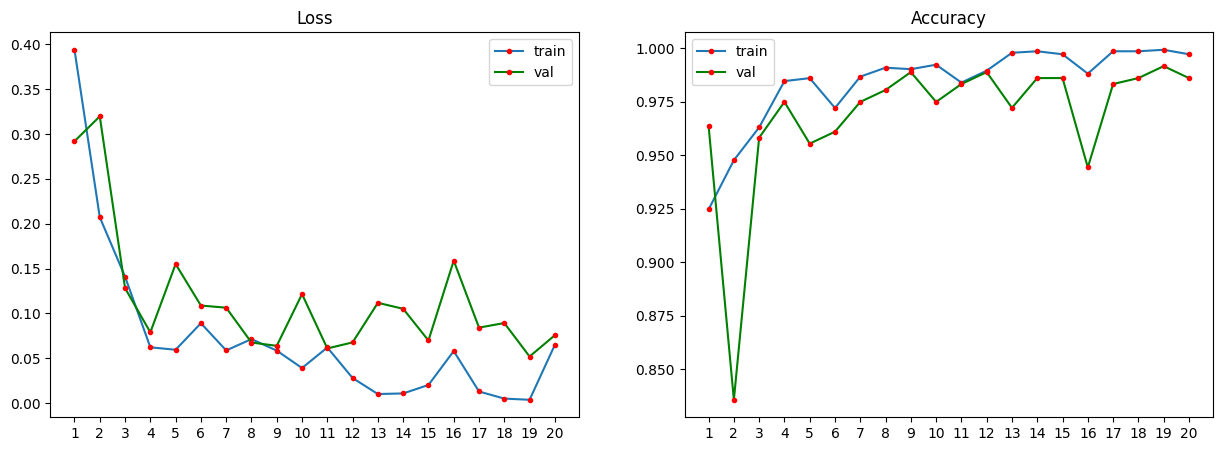

In [26]:
best_model_d3, train_loss, test_loss, train_acc, test_acc = train(dataloaders_d3, model_d3)
logs = {'train_loss': train_loss, 'train_acc': train_acc, 'valid_loss': test_loss, 'valid_acc': test_acc}
with open(f'ours_d3_training_logs.json', 'w') as f:
    json.dump(logs, f)
plot(train_loss, train_acc, test_loss, test_acc)

Epoch: [1/20]
Validation Loss improved, Saving Model...

  Train Acc    Val Acc    Train AUC    Val AUC
-----------  ---------  -----------  ---------
   0.732218    0.77095     0.808438   0.838686

Mean Train Loss: 0.753
Mean Val Loss: 0.837

Epoch: [2/20]
Validation Loss improved, Saving Model...

  Train Acc    Val Acc    Train AUC    Val AUC
-----------  ---------  -----------  ---------
   0.829847   0.871508      0.91912   0.915179

Mean Train Loss: 0.513
Mean Val Loss: 0.554

Epoch: [3/20]

  Train Acc    Val Acc    Train AUC    Val AUC
-----------  ---------  -----------  ---------
   0.892608   0.888268     0.951956   0.910648

Mean Train Loss: 0.386
Mean Val Loss: 0.584

Epoch: [4/20]
Validation Loss improved, Saving Model...

  Train Acc    Val Acc    Train AUC    Val AUC
-----------  ---------  -----------  ---------
    0.92887   0.882682     0.973239   0.947828

Mean Train Loss: 0.282
Mean Val Loss: 0.443

Epoch: [5/20]

  Train Acc    Val Acc    Train AUC    Val AUC
----

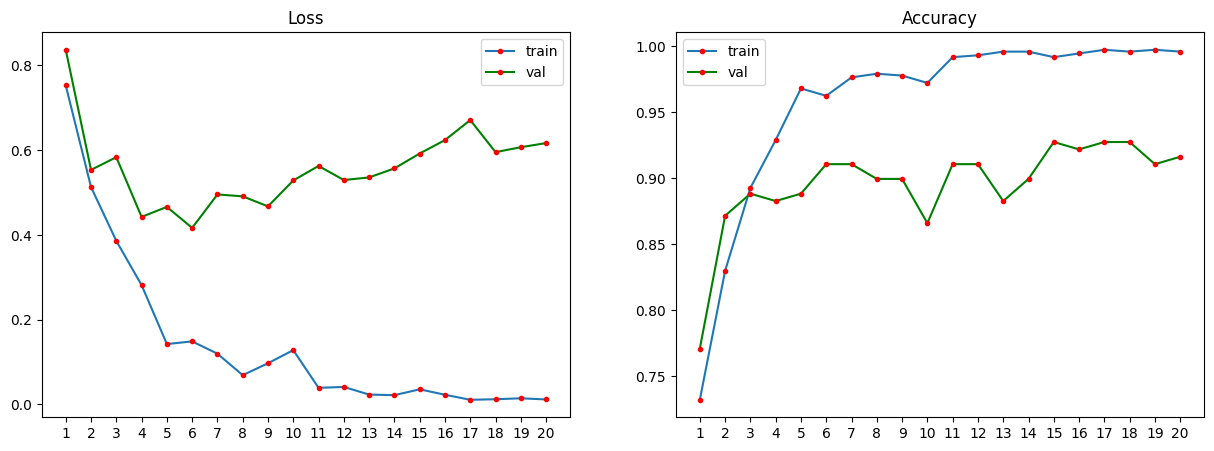

In [27]:
best_model_d5, train_loss, test_loss, train_acc, test_acc  = train(dataloaders_d5, model_d5)
logs = {'train_loss': train_loss, 'train_acc': train_acc, 'valid_loss': test_loss, 'valid_acc': test_acc}
with open(f'ours_d5_training_logs.json', 'w') as f:
    json.dump(logs, f)
plot(train_loss, train_acc, test_loss, test_acc)

In [28]:
def predict(best_model, test_loader):
    best_model.eval()
    model_preds = []
    # id_list = []
    with torch.no_grad():
        # Test out inference with 5 samples
        for idx, data in enumerate(test_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            predicts = best_model(inputs)
            preds =F.sigmoid(predicts.cpu()).numpy().flatten()
            y_pred = (preds > 0.4).astype(int)
            model_preds.extend(y_pred.tolist())
    
    return model_preds
test_df_d3['prediction'] = predict(best_model_d3, test_dataloader_d3)

In [29]:
test_df_d3

,Image,Class,prediction
0,/kaggle/input/world-championship-2023-embryo-c...,0,0
1,/kaggle/input/world-championship-2023-embryo-c...,0,0
2,/kaggle/input/world-championship-2023-embryo-c...,0,0
3,/kaggle/input/world-championship-2023-embryo-c...,0,0
4,/kaggle/input/world-championship-2023-embryo-c...,0,1
...,...,...,...
107,/kaggle/input/world-championship-2023-embryo-c...,0,0
108,/kaggle/input/world-championship-2023-embryo-c...,0,0
109,/kaggle/input/world-championship-2023-embryo-c...,0,0
110,/kaggle/input/world-championship-2023-embryo-c...,0,0


In [30]:
# torch.save(model, f'test_model.pth')
import json
from sklearn.metrics import classification_report
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
def export_result(test, model_name):
    accuracy = accuracy_score(test['Class'].astype(float), test['prediction'].astype(float))
    precision = precision_score(test['Class'].astype(float), test['prediction'].astype(float), average='weighted')
    recall = recall_score(test['Class'].astype(float), test['prediction'].astype(float), average='weighted')
    f1score = f1_score(test['Class'].astype(float), test['prediction'].astype(float), average='weighted')
    
    results = {'accuracy': accuracy, 'f1score': f1score, 'precision': precision, 'recall': recall}
    with open(f'{model_name}_result.json', 'w') as f:
        json.dump(results, f)

    return results
export_result(test_df_d3, 'efficientnet_b0_d3')

{'accuracy': 0.9375,
 'f1score': 0.9245391705069125,
 'precision': 0.9119318181818182,
 'recall': 0.9375}

In [31]:
test_df_d5['prediction'] = predict(best_model_d5, test_dataloader_d5)
export_result(test_df_d5, 'efficientnet_b0_d5')

{'accuracy': 0.7678571428571429,
 'f1score': 0.772644376899696,
 'precision': 0.8012224046706805,
 'recall': 0.7678571428571429}

In [32]:
test_df['prediction'] = predict(best_model_all, test_dataloader_all)
export_result(test_df, 'efficientnet_b0_1model')

{'accuracy': 0.8690476190476191,
 'f1score': 0.8746598639455782,
 'precision': 0.8830911455705428,
 'recall': 0.8690476190476191}

In [33]:
test_pred = pd.concat([test_df_d3, test_df_d5])
export_result(test_pred, 'efficientnet_b0')

{'accuracy': 0.8809523809523809,
 'f1score': 0.8845172426732708,
 'precision': 0.8894342653955654,
 'recall': 0.8809523809523809}

## Grad-Cam visualization

In [38]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

def cam_visualization(paths, model, title):
    fig, axes = plt.subplots(2, len(paths), figsize=(20, 6))
    # Flatten the axes array for easy iteration
    axes = axes.flatten()
    heat_maps = []
    for i, image_path in enumerate(paths):
        img = cv2.imread(image_path)
        #     greyscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)/255
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)/255
        img = cv2.resize(img, (256, 256))
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])
        image = Image.open(image_path)
        input_tensor = transform(image).unsqueeze(0)
        # Note: input_tensor can be a batch tensor with several images!
        
        # Construct the CAM object once, and then re-use it on many images:
        cam = GradCAM(model=model, target_layers=model.feature_extractor.features[-1])

        targets = [BinaryClassifierOutputTarget(1)]

        # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

        # In this example grayscale_cam has only one image in the batch:
        grayscale_cam = grayscale_cam[0, :]
        heat_maps.append(grayscale_cam)
        visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
        ax = axes[i]
        ax.imshow(visualization)  
        ax.set_title(image_path.split('/')[-1])
        ax.axis('off')  # Turn off axis labels
    
        ax2 = axes[i+5]
        ax2.imshow(grayscale_cam)
        ax2.set_title(image_path.split('/')[-1])
        ax2.axis('off')
    plt.suptitle('Grad-Cam with ' + title)
    plt.tight_layout()  # Adjust spacing between subplots for a better layout
    plt.savefig(title+'.png')
    plt.show()
        


#### Positive D3 images

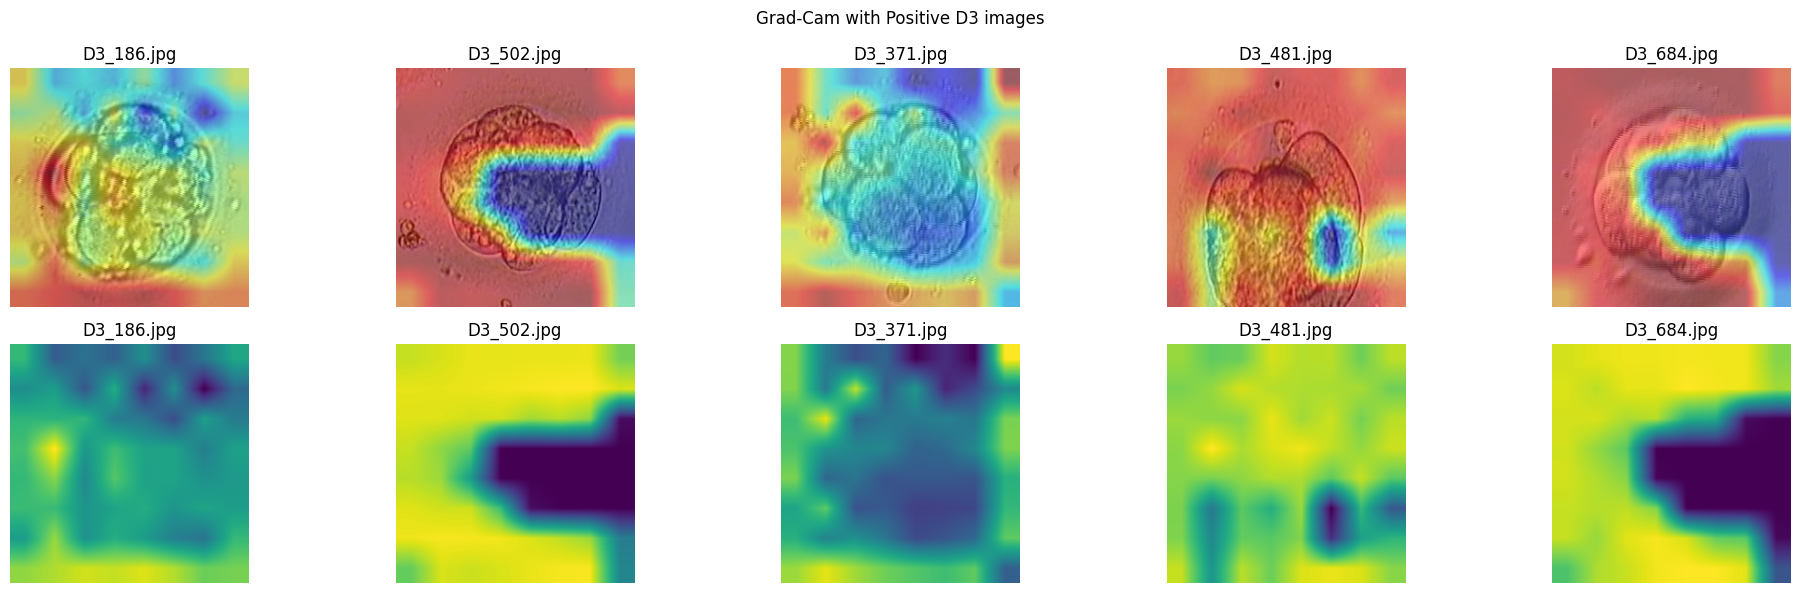

In [39]:
image_paths = ['/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D3_186.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D3_502.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D3_371.jpg',
              '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D3_481.jpg',
              '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D3_684.jpg']

cam_visualization(image_paths, best_model_d3, 'Positive D3 images')

#### Negative D3 image

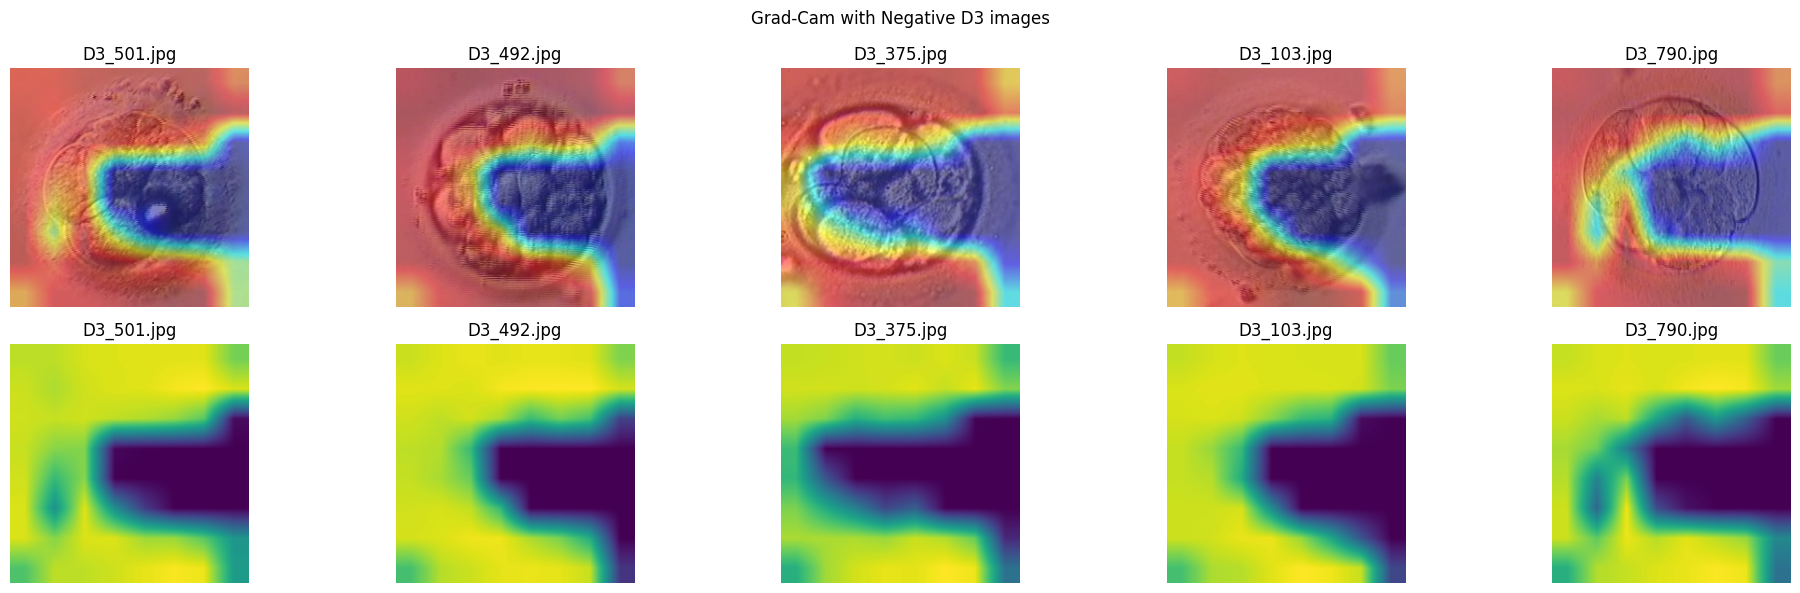

In [40]:
image_paths = ['/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D3_501.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D3_492.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D3_375.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D3_103.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D3_790.jpg']

cam_visualization(image_paths, best_model_d3, 'Negative D3 images')

#### Positive D5 images

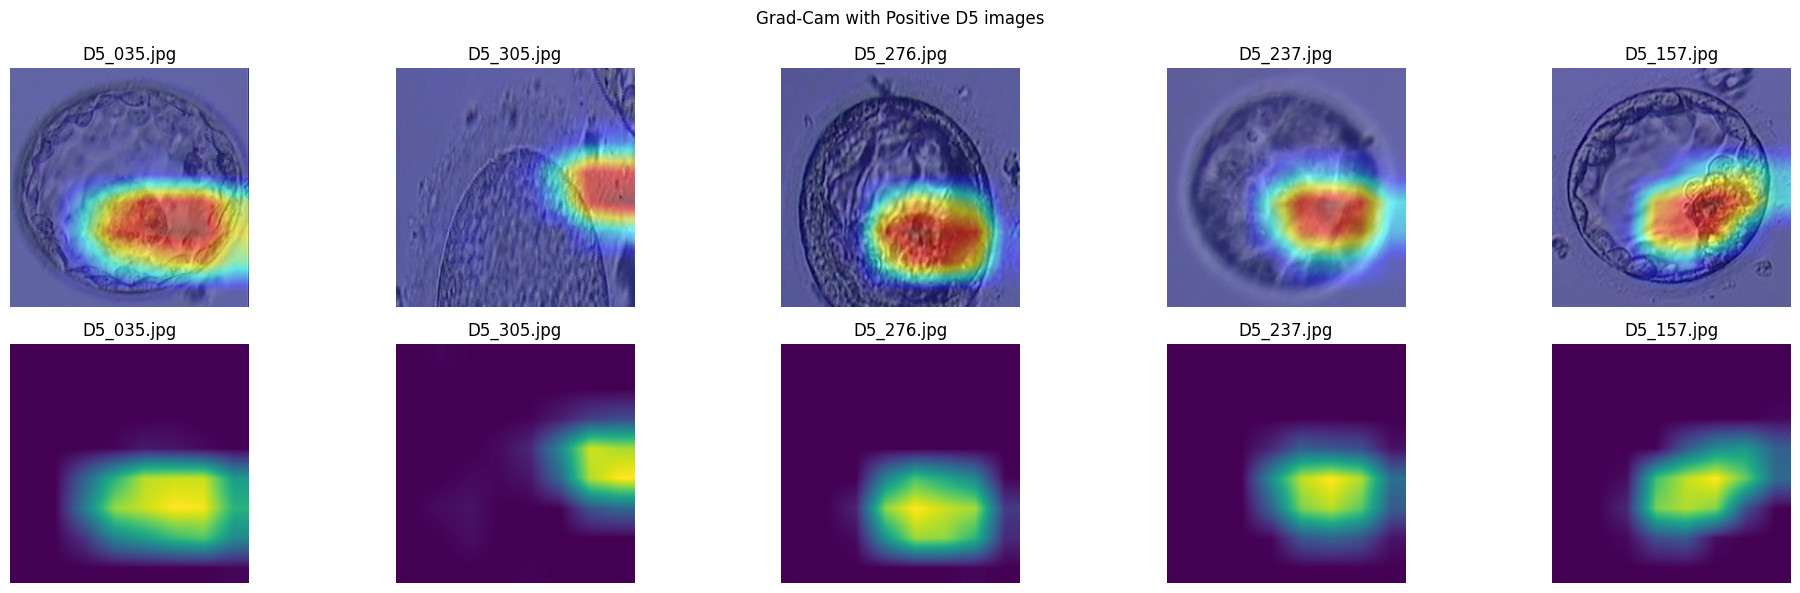

In [41]:
image_paths = ['/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D5_035.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D5_305.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D5_276.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D5_237.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D5_157.jpg']

cam_visualization(image_paths, best_model_d5, 'Positive D5 images')

#### Negative D5 images

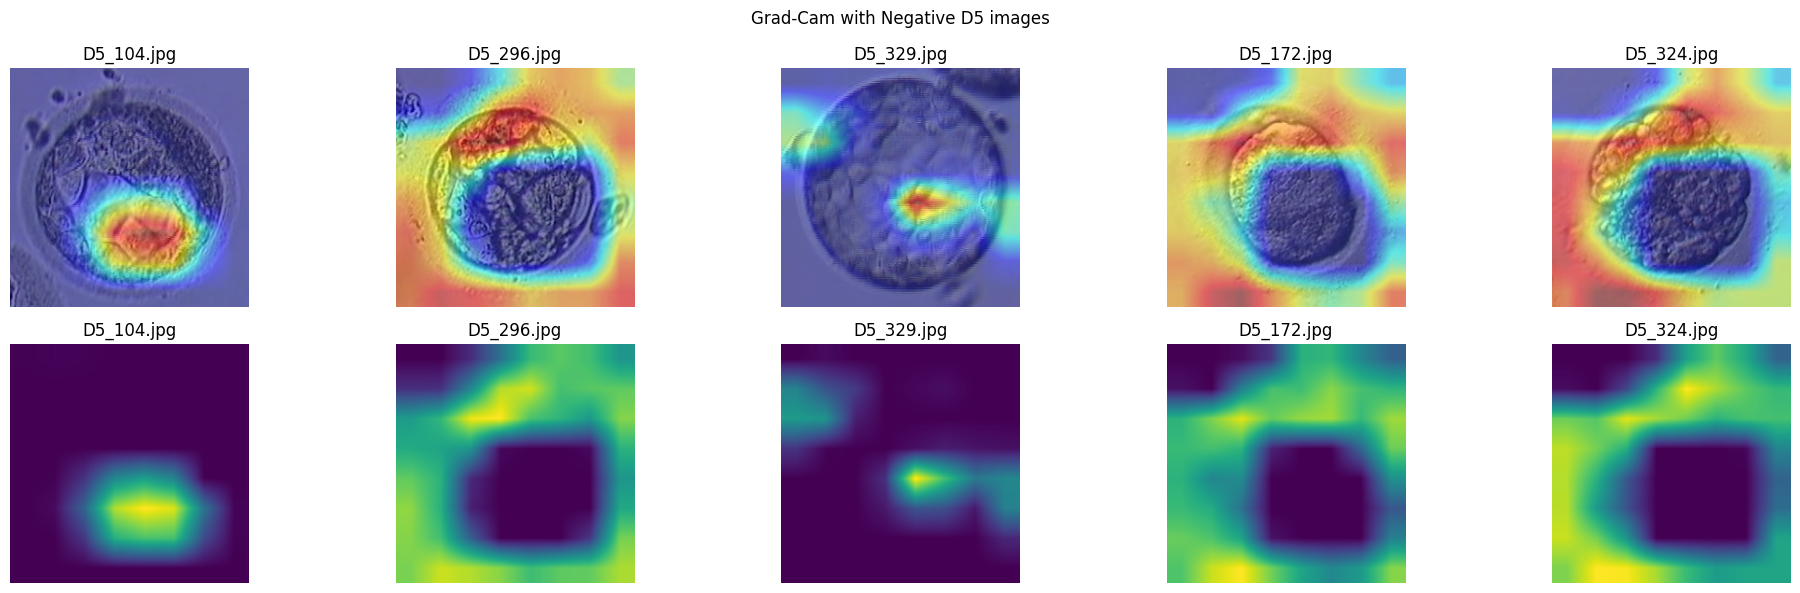

In [42]:
image_paths = ['/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D5_104.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D5_296.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D5_329.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D5_172.jpg',
               '/kaggle/input/world-championship-2023-embryo-classification/hvwc23/train/D5_324.jpg']

cam_visualization(image_paths, best_model_d5, 'Negative D5 images')

## Bootstrap sampling

In [43]:
data_train = pd.read_csv('/kaggle/input/embryo-split/train.csv')
data_val = pd.read_csv('/kaggle/input/embryo-split/test.csv')
data_val

,Image,Class
0,/kaggle/input/world-championship-2023-embryo-c...,0
1,/kaggle/input/world-championship-2023-embryo-c...,0
2,/kaggle/input/world-championship-2023-embryo-c...,0
3,/kaggle/input/world-championship-2023-embryo-c...,0
4,/kaggle/input/world-championship-2023-embryo-c...,0
...,...,...
163,/kaggle/input/world-championship-2023-embryo-c...,0
164,/kaggle/input/world-championship-2023-embryo-c...,0
165,/kaggle/input/world-championship-2023-embryo-c...,0
166,/kaggle/input/world-championship-2023-embryo-c...,1


In [ ]:
from sklearn import metrics
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

import warnings
warnings.filterwarnings('ignore')# Load the iris dataset

def bootstrap(X, y, n_samples=2000):
    models = []
    accuracys = []
    precisions = []
    recalls = []
    f1_scores = []

    for i in range(n_samples):
        if i % 10 == 0:
            print(i)
        X_bs, y_bs = resample(X, y, replace=True)
        bs_data = pd.concat([X_bs, y_bs], axis=1).reset_index().drop(columns=['index'])
#         print(bs_data)
        data_bs = EmbryoData(bs_data, current_fold=0)
        dataloader_bs = DataLoader(data_bs,batch_size = BATCH_SIZE, shuffle = False)
#         dataloader_bs = [(train_dataloader_d5, val_dataloader_d5)]
#         print(pd.DataFrame([X_bs, y_bs]))
        preds = predict(best_model_all, dataloader_bs)
        accuracys.append(accuracy_score(bs_data['Class'].astype(float), preds))
        precisions.append(precision_score(bs_data['Class'].astype(float), preds, average='weighted'))
        recalls.append(recall_score(bs_data['Class'].astype(float), preds, average='weighted'))
        f1_scores.append(f1_score(bs_data['Class'].astype(float), preds, average='weighted'))

#         results = {'accuracy': accuracy, 'f1score': f1score, 'precision': precision, 'recall': recall}
#         print(results)
#         break
        
    # Save the results to a Pandas dataframe
    pred_df = pd.DataFrame(
        {
            "Accuracy": accuracys,
            "Precision": precisions,
            "Recall": recalls,
            "F1": f1_scores,
        }
    )
    pred_df.to_csv('boostraping.csv')
    return pred_df
    
bs_results = bootstrap(valid_df['Image'], valid_df['Class'], n_samples=2000)

bs_results

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460


In [ ]:
import seaborn as sns

# plot
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=True, dpi=100)
sns.distplot(bs_results['F1'] , hist = False, color="dodgerblue", ax=axes[0])
sns.distplot(bs_results['Recall'] , hist = False, color="deeppink", ax=axes[1])
sns.distplot(bs_results['Precision'] , hist = False, color="gold", ax=axes[2])